## Tasks:
1. **Environment Setup**
2. **Load IMDb dataset (50,000 records)**
3. **Data preparation**

## Environment Setup

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [9]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import re
import string
import time
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.layers import Layer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,Conv1D, Bidirectional, LSTM,Dropout,Input,Embedding,TextVectorization)
from keras.preprocessing.text import one_hot, Tokenizer
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [487]:
# Change directory to the project folder
# data_path = '/content/drive/My Drive/Colab Notebooks/imdb_sentiment_analysis_model'
data_path = '/Users/loc/Desktop/Git/23mse43006/7.ML/FinalAssignment/application/models/sentiment_analysic/dataset/imdb_dataset_50k.csv'

## Load IMDb dataset(50,000 records)


In [488]:
movie_reviews = pd.read_csv(data_path)

# Convert the sentiment column to binary
movie_reviews['sentiment'] = movie_reviews['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [489]:
# Display the first 5 rows of the dataset
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [490]:
# Check the shape of the dataset
movie_reviews.shape

(50000, 2)

In [491]:
# Check for missing values
movie_reviews.isnull().sum()

review       0
sentiment    0
dtype: int64

<Axes: xlabel='sentiment', ylabel='count'>

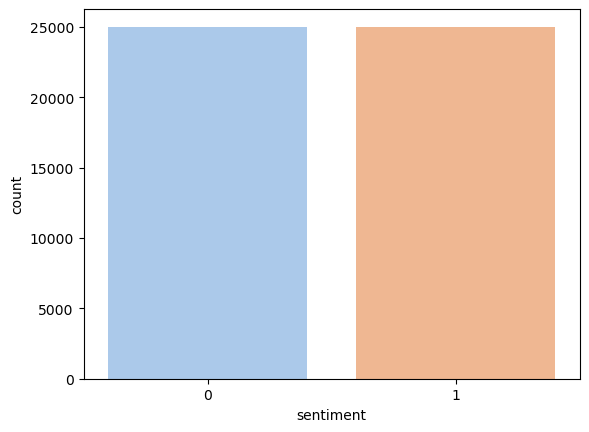

In [492]:
# Plot the count of each sentiment
sns.countplot(x='sentiment', data=movie_reviews, hue='sentiment', palette='pastel', legend=False)

## Data Preparation

In [493]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/loc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [494]:
import unicodedata

# Get the list of English stopwords
stop_words = set(stopwords.words('english'))

# Convert the stopwords to a TensorFlow constant
stopwords_tensor = tf.constant(list(stop_words))

def remove_stopwords(sentence):
    words = tf.strings.split(sentence)
    filtered_words = tf.boolean_mask(words, tf.math.logical_not(tf.reduce_any(tf.equal(words[:, None], stopwords_tensor[None, :]), axis=1)))
    sentence = tf.strings.reduce_join(filtered_words, separator=' ')
    return sentence

def standardization(sen):
    
    lowercase = tf.strings.lower(sen)

    # Remove punctuations and numbers
    sentence = tf.strings.regex_replace(lowercase, '[^a-z]', ' ')
    
    # Take off of html tag
    sentence = tf.strings.regex_replace(sentence, '<[^>]+>', ' ')
    
    # Single character removal
    sentence = tf.strings.regex_replace(sentence, r'\b\w\b', ' ')
    
    # Remove multiple spaces
    sentence = tf.strings.regex_replace(sentence, ' +', ' ')
    
    # Remove stopwords #FIXME
    # sentence = remove_stopwords(sentence)
    
    # Normalize UTF-8 and remove accented characters using standard Python libraries #FIXME
    # def normalize_and_remove_accents(text):
    #     text = unicodedata.normalize('NFKD', text.numpy().decode('utf-8'))
    #     return ''.join(c for c in text if unicodedata.category(c) != 'Mn')

    # sentence = tf.py_function(normalize_and_remove_accents, [sentence], tf.string)

    return sentence


In [495]:
# movie_reviews['review'][2]
# Example usage
sentence = tf.constant("lộc This is a sample sentence, showing off the stop words filtration.")
standardization(sentence)

<tf.Tensor: shape=(), dtype=string, numpy=b' this is sample sentence showing off the stop words filtration '>

In [496]:
standardization(movie_reviews['review'][2])

<tf.Tensor: shape=(), dtype=string, numpy=b' thought this was wonderful way to spend time on too hot summer weekend sitting in the air conditioned theater and watching light hearted comedy the plot is simplistic but the dialogue is witty and the characters are likable even the well bread suspected serial killer while some may be disappointed when they realize this is not match point risk addiction thought it was proof that woody allen is still fully in control of the style many of us have grown to love br br this was the most laughed at one of woody comedies in years dare say decade while ve never been impressed with scarlet johanson in this she managed to tone down her sexy image and jumped right into average but spirited young woman br br this may not be the crown jewel of his career but it was wittier than devil wears prada and more interesting than superman great comedy to go see with friends '>

## Preparing embedding layer

### Manual

In [497]:
# word_tokenizer = Tokenizer()
# word_tokenizer.fit_on_texts(X_train) # create a dictionary

# X_train = word_tokenizer.texts_to_sequences(X_train) # match the words in the dictionary to the words in the sentences
# X_test = word_tokenizer.texts_to_sequences(X_test)
# len(word_tokenizer.word_index)
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

# vocab_length = len(word_tokenizer.word_index) + 1

# vocab_length
# len(X_train)
# for i in range(10):
#     print(len(X_train[i]))
# Padding all reviews to fixed length 100

# maxlen = 100

# X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
# X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
# len(X_train)
# for i in range(10):
#     print(X_train)

### Keras TextVectorization

In [498]:
# Define hyperparameters
# 1. Batch size for training and validation (64)
BATCH_SIZE=64
# 2. Maximum vocabulary size (10,000)
VOCAB_SIZE=10000
# 3. Maximum sequence length to pad the sentences to (250)
SEQUENCE_LENGTH=250

In [499]:
# Create a TextVectorization layer to vectorize and standardize text data for the model
# Include tokenization, standardization, and vectorization in one layer
vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)

In [500]:
# Split the dataset into training and testing sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(movie_reviews['review'], movie_reviews['sentiment'], test_size=0.2, random_state=42)

# Create a tf.data.Dataset object for the training and validation sets
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))

print("Building the dictionary...")

start_time = time.time()

# Only extract the train from the dataset
vectorize_layer.adapt(train_data.map(lambda train, label: train))

end_time = time.time()

print("Time taken to build the dictionary: ", end_time - start_time)


Building the dictionary...


2024-07-10 16:31:13.133763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [40000]
	 [[{{node Placeholder/_1}}]]


Time taken to build the dictionary:  13.50248122215271


In [501]:
# print 4 first records of X_val
for i in range(4):
    print(X_val.iloc[i])

I really liked this Summerslam due to the look of the arena, the curtains and just the look overall was interesting to me for some reason. Anyways, this could have been one of the best Summerslam's ever if the WWF didn't have Lex Luger in the main event against Yokozuna, now for it's time it was ok to have a huge fat man vs a strong man but I'm glad times have changed. It was a terrible main event just like every match Luger is in is terrible. Other matches on the card were Razor Ramon vs Ted Dibiase, Steiner Brothers vs Heavenly Bodies, Shawn Michaels vs Curt Hening, this was the event where Shawn named his big monster of a body guard Diesel, IRS vs 1-2-3 Kid, Bret Hart first takes on Doink then takes on Jerry Lawler and stuff with the Harts and Lawler was always very interesting, then Ludvig Borga destroyed Marty Jannetty, Undertaker took on Giant Gonzalez in another terrible match, The Smoking Gunns and Tatanka took on Bam Bam Bigelow and the Headshrinkers, and Yokozuna defended the

In [502]:
# Display the words in the vocabulary with their vector representations
# for i in range(1):
#     print(X_train[i])
#     print(vectorize_layer(X_val[i]))

# print X_val
for i in range(1):
    print(X_val.iloc[i])
    print(vectorize_layer(X_val.iloc[i]))

I really liked this Summerslam due to the look of the arena, the curtains and just the look overall was interesting to me for some reason. Anyways, this could have been one of the best Summerslam's ever if the WWF didn't have Lex Luger in the main event against Yokozuna, now for it's time it was ok to have a huge fat man vs a strong man but I'm glad times have changed. It was a terrible main event just like every match Luger is in is terrible. Other matches on the card were Razor Ramon vs Ted Dibiase, Steiner Brothers vs Heavenly Bodies, Shawn Michaels vs Curt Hening, this was the event where Shawn named his big monster of a body guard Diesel, IRS vs 1-2-3 Kid, Bret Hart first takes on Doink then takes on Jerry Lawler and stuff with the Harts and Lawler was always very interesting, then Ludvig Borga destroyed Marty Jannetty, Undertaker took on Giant Gonzalez in another terrible match, The Smoking Gunns and Tatanka took on Bam Bam Bigelow and the Headshrinkers, and Yokozuna defended the

In [503]:
vectorize_layer.get_vocabulary()[22]

'are'

In [504]:
print("Starting vectorization...")

def vectorizer(review, label):
    return vectorize_layer(review),label

start_time = time.time()

# train_dataset = vectorize_layer(X_train)
# val_dataset = vectorize_layer(X_val)

train_dataset = train_data.map(lambda x, y: (vectorize_layer(x), y))
val_dataset = val_data.map(lambda x, y: (vectorize_layer(x), y))

end_time = time.time()

print("Time taken to vectorize the dataset: ", end_time - start_time)

Starting vectorization...
Time taken to vectorize the dataset:  0.06215810775756836


## Models Training:

### Simple RNN:

In [476]:
# Define hyperparameters
# 1. Batch size for training and validation (64)
BATCH_SIZE=64
# 2. Maximum vocabulary size (10,000)
VOCAB_SIZE=10000
# 3. Maximum sequence length to pad the sentences to (250)
SEQUENCE_LENGTH=250
# 4. Embedding dimension (64)
EMBEDDING_DIM = 64

model=tf.keras.models.Sequential([
    
    Input(shape=(SEQUENCE_LENGTH,)),
    
    Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    
    SimpleRNN(32),
    
    Dense(1,activation='sigmoid'),
])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 250, 64)           640000    
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 643,137
Trainable params: 643,137
Non-trainable params: 0
_________________________________________________________________


In [477]:
# checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/sentiment_analysis/imdb_simple_rnn_checkpoint.keras'
checkpoint_filepath = '/Users/loc/Desktop/Git/23mse43006/7.ML/FinalAssignment/application/models/sentiment_analysic/check_points/imdb_simple_rnn_checkpoint.keras'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [438]:
# Mac M1/M2 happy with legacy: tf.keras.optimizers.legacy.Adam(1e-4)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer= tf.keras.optimizers.legacy.Adam(1e-4), #tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [439]:
# Model training
start_time = time.time()

print("Training the model...")

BATCH_SIZE=64

# Batch and prefetch the dataset
train_data = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

history=model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[model_checkpoint_callback])

# model.save_weights("/content/drive/MyDrive/Colab Notebooks/sentiment_analysis/text_sentiment_analysis.h5")
model.save("/Users/loc/Desktop/Git/23mse43006/7.ML/FinalAssignment/application/models/sentiment_analysic/output/imdb_simple_rnn.h5")

end_time = time.time()

print("Time taken to train the model: ", end_time - start_time)

Training the model...
Epoch 1/10


2024-07-10 15:19:23.092133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [40000]
	 [[{{node Placeholder/_1}}]]


625/625 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.5138

2024-07-10 15:19:39.523271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10000]
	 [[{{node Placeholder/_0}}]]


625/625 [==============================] - 18s 29ms/step - loss: 0.6927 - accuracy: 0.5138 - val_loss: 0.6814 - val_accuracy: 0.5894
Epoch 2/10
625/625 [==============================] - 18s 29ms/step - loss: 0.6839 - accuracy: 0.5540 - val_loss: 0.6679 - val_accuracy: 0.6106
Epoch 3/10
625/625 [==============================] - 18s 29ms/step - loss: 0.6345 - accuracy: 0.6578 - val_loss: 0.6490 - val_accuracy: 0.6469
Epoch 4/10
625/625 [==============================] - 18s 29ms/step - loss: 0.5517 - accuracy: 0.7521 - val_loss: 0.4922 - val_accuracy: 0.8076
Epoch 5/10
625/625 [==============================] - 18s 29ms/step - loss: 0.4035 - accuracy: 0.8500 - val_loss: 0.4005 - val_accuracy: 0.8446
Epoch 6/10
625/625 [==============================] - 18s 29ms/step - loss: 0.3096 - accuracy: 0.8905 - val_loss: 0.3459 - val_accuracy: 0.8633
Epoch 7/10
625/625 [==============================] - 18s 29ms/step - loss: 0.2581 - accuracy: 0.9126 - val_loss: 0.3555 - val_accuracy: 0.8711
Epo

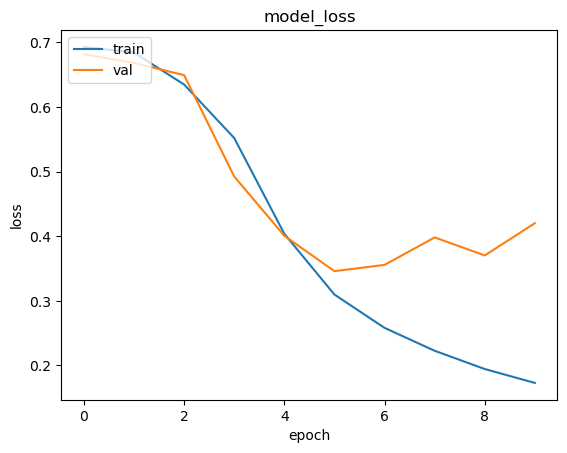

In [442]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

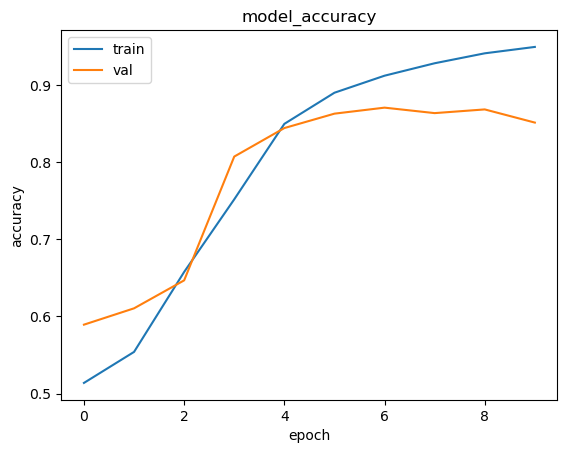

In [443]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### LSTM (MultiLayer and Bidirectional):

In [478]:
# Define hyperparameters
# 1. Batch size for training and validation (64)
BATCH_SIZE=64
# 2. Maximum vocabulary size (10,000)
VOCAB_SIZE=10000
# 3. Maximum sequence length to pad the sentences to (250)
SEQUENCE_LENGTH=250
# 4. Embedding dimension (64)
EMBEDDING_DIM = 64

model=tf.keras.models.Sequential([

    Input(shape=(SEQUENCE_LENGTH,)),

    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Bidirectional(LSTM(64,return_sequences=True)),

    Bidirectional(LSTM(32)),

    Dense(64, activation='relu'),

    Dropout(0.5),

    Dense(1,activation='sigmoid'),
])

model.summary()

2024-07-10 15:54:44.258127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-10 15:54:44.258678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-10 15:54:44.259281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 250, 64)           640000    
                                                                 
 bidirectional_8 (Bidirectio  (None, 250, 128)         66048     
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 1)               

In [482]:
# checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/sentiment_analysis/imdb_lstm_checkpoint.keras'
checkpoint_filepath = '/Users/loc/Desktop/Git/23mse43006/7.ML/FinalAssignment/application/models/sentiment_analysic/check_points/imdb_lstm_checkpoint.keras'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [480]:
# Mac M1/M2 happy with legacy: tf.keras.optimizers.legacy.Adam(1e-4)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer= tf.keras.optimizers.legacy.Adam(1e-4), #tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [483]:
# Model training
start_time = time.time()

print("Training the model...")

BATCH_SIZE=64

# Batch and prefetch the dataset
train_data = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

history=model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[model_checkpoint_callback])

# model.save("/content/drive/MyDrive/Colab Notebooks/sentiment_analysis/output/imdb_lstm.h5")
model.save("/Users/loc/Desktop/Git/23mse43006/7.ML/FinalAssignment/application/models/sentiment_analysic/output/imdb_lstm.h5")

end_time = time.time()

print("Time taken to train the model: ", end_time - start_time)

Training the model...
Epoch 1/10


2024-07-10 15:59:20.690658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [40000]
	 [[{{node Placeholder/_1}}]]


625/625 [==============================] - 132s 212ms/step - loss: 0.2824 - accuracy: 0.8906 - val_loss: 0.2798 - val_accuracy: 0.8820
Epoch 2/10
625/625 [==============================] - 137s 219ms/step - loss: 0.2370 - accuracy: 0.9130 - val_loss: 0.2931 - val_accuracy: 0.8802
Epoch 3/10
625/625 [==============================] - 134s 215ms/step - loss: 0.2066 - accuracy: 0.9287 - val_loss: 0.3196 - val_accuracy: 0.8754
Epoch 4/10
625/625 [==============================] - 138s 221ms/step - loss: 0.1848 - accuracy: 0.9389 - val_loss: 0.3360 - val_accuracy: 0.8769
Epoch 5/10
625/625 [==============================] - 139s 222ms/step - loss: 0.1677 - accuracy: 0.9474 - val_loss: 0.3897 - val_accuracy: 0.8649
Epoch 6/10
625/625 [==============================] - 132s 211ms/step - loss: 0.1641 - accuracy: 0.9475 - val_loss: 0.3672 - val_accuracy: 0.8766
Epoch 7/10
625/625 [==============================] - 132s 211ms/step - loss: 0.1496 - accuracy: 0.9520 - val_loss: 0.4215 - val_accura

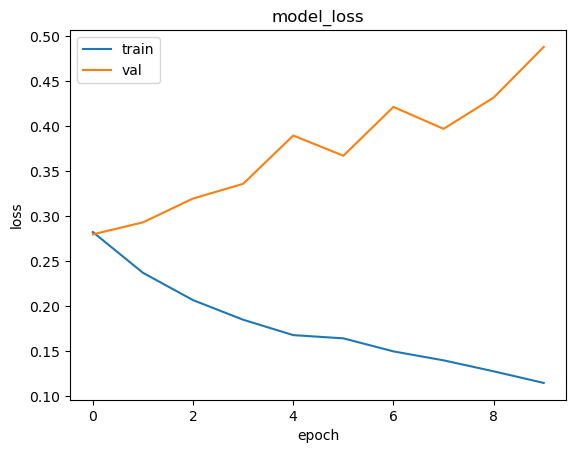

In [484]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

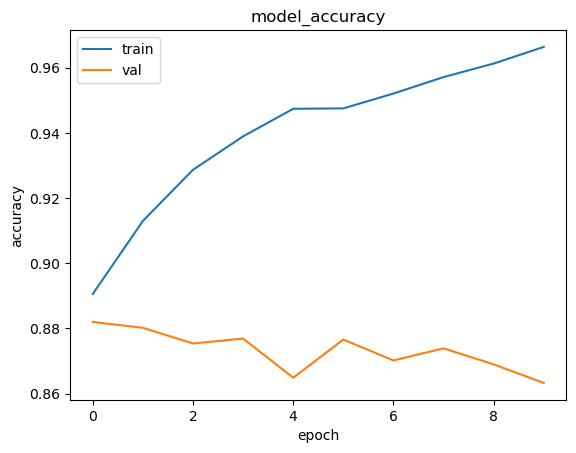

In [485]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Pretrained Word2Vec[Gensim]

In [4]:
import gensim.downloader as api
import gensim
# google_news_news_300_path = "/content/drive/MyDrive/Colab Notebooks/Embeddings/GoogleNews-vectors-negative300.bin"
google_news_news_300_path = "/Users/loc/Desktop/Git/23mse43006/7.ML/FinalAssignment/application/models/sentiment_analysic/embeddings/GoogleNews-vectors-negative300.bin"
# word2vec = api.load('word2vec-google-news-300')

# Load the model
word2vec = gensim.models.KeyedVectors.load_word2vec_format(google_news_news_300_path, binary=True)
word2vec.vectors.shape

ImportError: cannot import name 'triu' from 'scipy.linalg' (/Users/loc/Documents/anaconda3/lib/python3.12/site-packages/scipy/linalg/__init__.py)

In [5]:
# Testing purpose
# print(word2vec.vocab)
word2vec['The']
word2vec.most_similar('Man')
word2vec.key_to_index

NameError: name 'word2vec' is not defined

In [ ]:
def first_caps(word):
  return word[0].upper()+word[1:]

In [ ]:
pretrained_embeddings=[]

# for i in range(len(vectorize_layer.get_vocabulary())):
#   try:
#     pretrained_embeddings.append(word2vec[vectorize_layer.get_vocabulary()[i]])
#   except:
#     print(vectorize_layer.get_vocabulary()[i])
#     try:
#       pretrained_embeddings.append(word2vec[first_caps(vectorize_layer.get_vocabulary()[i])])
#       print('toupper')
#     except:
#       print('nosolution')
#       pretrained_embeddings.append(random.normal(loc=0, scale=1, size=(EMBEDDING_DIM)))#reloaded_word_vectors[vectorize_layer.get_vocabulary()[i]])
#   if i%1000==0:
#     print('iis====================================',i)

unfound_words = []
unfound_words_count = 0
found_words_count = 0

for word in vectorize_layer.get_vocabulary():
    if word in word2vec.key_to_index:
        found_words_count += 1
        pretrained_embeddings.append(word2vec[word])
    else:
        # Nếu từ không có trong mô hình Word2Vec, thêm một vector zeros
        unfound_words_count+=1
        unfound_words.append(word)
        pretrained_embeddings.append(np.zeros(300))


print(f"Found words count: {found_words_count}")

print(f"Unfound words ount: {unfound_words_count}")

print(f"Pretrained embeddings shape: {np.array(pretrained_embeddings).shape}")
#
# for word in unfound_words:
#     print(word)

In [ ]:
# Testing purpose
# vectorize_layer.get_vocabulary()[2]
# first_caps(vectorize_layer.get_vocabulary()[2])

In [ ]:
# pretrained_embeddings_array=np.array(pretrained_embeddings)
# print(pretrained_embeddings_array.shape)

# Giả sử pretrained_embeddings là danh sách các vector embedding đã được tải
# từ mô hình Word2Vec

# Kiểm tra kích thước của các vector embedding
embedding_dim = len(pretrained_embeddings[0])

print(f"Kích thước của các vector embedding: {embedding_dim}")

# Tạo mảng NumPy từ danh sách pretrained_embeddings
pretrained_embeddings_array = np.array(pretrained_embeddings)

# In kích thước của mảng NumPy
print(pretrained_embeddings_array.shape)

In [ ]:
# np.save('/content/drive/MyDrive/Colab Notebooks/sentiment_analysis/pretrained_embeddings',pretrained_embeddings_array)
np.save('/Users/loc/Desktop/Git/23mse43006/7.ML/FinalAssignment/application/models/sentiment_analysic/embedding',pretrained_embeddings_array)

In [10]:
# pretrained_embeddings_array=np.load('/content/drive/MyDrive/Colab Notebooks/sentiment_analysis/pretrained_embeddings.npy')
pretrained_embeddings_array=np.load('/Users/loc/Desktop/Git/23mse43006/7.ML/FinalAssignment/application/models/sentiment_analysic/embedding/pretrained_embeddings.npy')
pretrained_embeddings_array.shape

FileNotFoundError: [Errno 2] No such file or directory: '/Users/loc/Desktop/Git/23mse43006/7.ML/FinalAssignment/application/models/sentiment_analysic/embedding/pretrained_embeddings.npy'

In [11]:
# Define hyperparameters
# 1. Batch size for training and validation (64)
BATCH_SIZE=64
# 2. Maximum vocabulary size (10,000)
VOCAB_SIZE=10000
# 3. Maximum sequence length to pad the sentences to (250)
SEQUENCE_LENGTH=250
# 4. Embedding dimension
EMBEDDING_DIM=pretrained_embeddings_array.shape[1]

model=tf.keras.models.Sequential([

    Input(shape=(SEQUENCE_LENGTH,)),

    Embedding(
        VOCAB_SIZE,
        EMBEDDING_DIM,
        embeddings_initializer=tf.keras.initializers.Constant(pretrained_embeddings_array),
        trainable=True,
    ),

    Conv1D(32, 3, activation='relu'),

    Flatten(),

    Dense(32, activation='relu'),

    Dropout(0.5),

    Dense(1,activation='sigmoid'),
])

model.summary()

NameError: name 'pretrained_embeddings_array' is not defined

In [ ]:
# checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/sentiment_analysis/imdb_conv_1d_word2vec_check_point.h5'
checkpoint_filepath = '/Users/loc/Desktop/Git/23mse43006/7.ML/FinalAssignment/application/models/sentiment_analysic/check_points/imdb_conv_1d_word2vec_check_point.h5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_callback])

# model.save("/content/drive/MyDrive/Colab Notebooks/sentiment_analysis/imdb_conv_1d_word2vec.h5")
model.save("/Users/loc/Desktop/Git/23mse43006/7.ML/FinalAssignment/application/models/sentiment_analysic/output/imdb_conv_1d_word2vec.h5")

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()